# 3.1 线性回归
线性回归输出是一个连续值，因此适用于回归问题。回归问题在实际中很常见，如预测房屋价格、气温、销售额等连续值的问题。与回归问题不同，分类问题中模型的最终输出是一个离散值。我们所说的图像分类、垃圾邮件识别、疾病检测等输出为离散值的问题都属于分类问题的范畴。softmax回归则适用于分类问题。

由于线性回归和softmax回归都是单层神经网络，它们涉及的概念和技术同样适用于大多数的深度学习模型。我们首先以线性回归为例，介绍大多数深度学习模型的基本要素和表示方法。

## 3.1.1 线性回归的基本要素
我们以一个简单的房屋价格预测作为例子来解释线性回归的基本要素。这个应用的目标是预测一栋房子的售出价格（元）。我们知道这个价格取决于很多因素，如房屋状况、地段、市场行情等。为了简单起见，这里我们假设价格只取决于房屋状况的两个因素，即面积（平方米）和房龄（年）。接下来我们希望探索价格与这两个因素的具体关系。

### 3.1.1.1 模型定义
设房屋的面积为 $ x_1 $​	，房龄为 $x_2$​，售出价格为 $y$。我们需要建立基于输入 $x_1$和 x2来计算输出 $ y $的表达式，也就是模型（model）。顾名思义，线性回归假设输出与各个输入之间是线性关系：$$ \hat{y} = x_1w_1 + x_2w_2+b $$ 其中 $w_1$ 和 $w_2$ 是权重（weight），是偏差（bias），且均为标量。它们是线性回归模型的参数（parameter）。模型输出$\hat{y}$是线性回归对真实价格$y$的预测或估计。我们通常允许它们之间有一定误差。

### 3.1.1.2 模型训练
接下来我们需要通过数据来寻找特定的模型参数值，使模型在数据上的误差尽可能小。这个过程叫作模型训练（model training）。下面我们介绍模型训练所涉及的3个要素。

#### (1)训练数据
#### (2)损失函数
#### (3)优化算法

### 3.1.1.3 模型预测

## 3.1.2 线性回归的表示方法
### 3.1.2.1 神经网络图
### 3.1.2.2 矢量计算表达式



In [1]:
import torch
from time import time

a = torch.ones(1000)
b = torch.ones(1000)

In [2]:
start = time()
c = torch.zeros(1000)
for i in range(1000):
    c[i] = a[i] + b[i]
print(time() - start)

0.023433208465576172


In [8]:
# 向量相加的另一种方法是，将这两个向量直接做矢量加法。
start = time()
d = a + b
print(time() - start)

#结果很明显，后者比前者更省时。因此，我们应该尽可能采用矢量计算，以提升计算效率。

0.00011587142944335938


In [9]:
a = torch.ones(3)
b = 10
print(a + b)

tensor([11., 11., 11.])


# 3.2 线性回归的从零开始实现

In [15]:
%matplotlib inline
import torch 
from IPython import display
from matplotlib import pyplot as plt 
import numpy as np 
import random

## 3.2.1生成数据集

In [16]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] *features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)
print(features[0], labels[0])

tensor([-0.7870,  1.5311]) tensor(-2.5880)


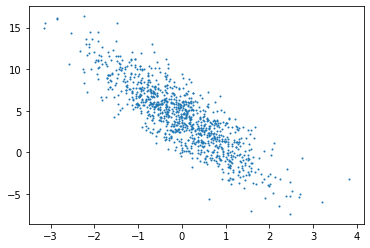

In [17]:
# 通过生成第二个特征features[:, 1]和标签 labels 的散点图，可以更直观地观察两者间的线性关系。
# def use_svg_display():
#     # 用矢量图显示
#     display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    # use_svg_display()
    #设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

## 3.2.2 读取数据
在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

In [21]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) #样本的读取顺序是随机的

    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i:min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield features.index_select(0,j), labels.index_select(0, j)

In [22]:
batch_size = 10
for X, y in data_iter(batch_size, features ,labels):
    print(X, y)
    break

tensor([[ 0.2902, -0.2529],
        [ 0.3798, -0.0485],
        [-0.3315, -0.5044],
        [-0.9878,  0.1998],
        [ 0.7205,  0.7539],
        [-1.6600, -0.6327],
        [ 0.5347,  0.2940],
        [ 0.6028,  0.8819],
        [-1.5917, -2.0076],
        [-0.3648, -0.1660]]) tensor([5.6405, 5.1099, 5.2529, 1.5533, 3.0906, 3.0183, 4.2598, 2.4012, 7.8569,
        4.0390])


## 3.2.3 初始化模型参数
将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [24]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

# 之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的requires_grad=True。
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

print(w, b)

tensor([[ 0.0179],
        [-0.0064]], requires_grad=True) tensor([0.], requires_grad=True)


## 3.2.4定义模型

In [25]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [29]:
def squared_loss(y_hat, y):
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 定义优化算法

In [43]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

## 3.2.7 训练模型

In [30]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features , labels):
        l = loss(net(X, w, b), y).sum() 
        l.backward()
        sgd([w, b], lr, batch_size)

        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()

    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.030307
epoch 2, loss 0.000099
epoch 3, loss 0.000049


In [31]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0000],
        [-3.4003]], requires_grad=True)
4.2 
 tensor([4.2003], requires_grad=True)


# 3.3 线性回归的简洁实现
## 3.3.1 生成数据集

In [18]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

## 读取数据
PyTorch提供了data包来读取数据。由于data常用作变量名，我们将导入的data模块用Data代替。在每一次迭代中，我们将随机读取包含10个数据样本的小批量。

In [19]:
import torch.utils.data as Data 

batch_size = 10
# 将训练数据特征和标签组合
dataset = Data.TensorDataset(features, labels)
#随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [35]:
for X,y in data_iter:
    print(X, y)
    break

tensor([[-1.5575,  3.6935],
        [ 1.1942,  0.2009],
        [-0.2711,  1.3183],
        [-0.0785, -0.2183],
        [ 0.5472, -1.2402],
        [-0.0370, -1.8741],
        [ 0.1241, -0.8140],
        [-0.0073, -1.1363],
        [-1.8598,  0.3146],
        [ 1.1975,  0.7633]]) tensor([-11.4613,   5.9086,  -0.8228,   4.7782,   9.5253,  10.4683,   7.2237,
          8.0518,  -0.5826,   3.9820])


## 3.3.3 定义模型

In [20]:
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)

    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net)


LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [22]:
# 用nn.Sequential来更加方便地搭建网络，Sequential是一个有序的容器，网络层将按照在传入Sequential的顺序依次被添加到计算图中。
net  = nn.Sequential(
    nn.Linear(num_inputs, 1)
)

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))

#写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(num_inputs,1))
]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [9]:
# 可以通过net.parameters()来查看模型所有的可学习参数，此函数将返回一个生成器。
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.4031,  0.4251]], requires_grad=True)
Parameter containing:
tensor([0.5097], requires_grad=True)


## 3.3.4 初始化模型参数

In [23]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0) # 也可以直接修改bias的data: net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

## 3.3.5定义损失函数

In [24]:
loss = nn.MSELoss()

## 定义优化算法

In [25]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [16]:
# 我们还可以为不同子网络设置不同的学习率，这在finetune时经常用到。例：
optimizer = optim.SGD([
    # 如果对某个参数不指定学习率，就使用最外层的默认学习率
    {'params': net.subnet1.parameters()}, # lr=0.03
    {'params': net.subnet2.parameters(), 'lr':0.01}
], lr=0.03)

In [ ]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍

## 3.3.7训练模型

In [26]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss:%f' % (epoch, l.item()))


epoch 1, loss:0.000287
epoch 2, loss:0.000100
epoch 3, loss:0.000100


In [28]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.9999, -3.4005]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2002], requires_grad=True)


# 3.4 softmax回归
对于这样的离散值预测问题，我们可以使用诸如softmax回归在内的分类模型。和线性回归不同，softmax回归的输出单元从一个变成了多个，且引入了softmax运算使输出更适合离散值的预测和训练。
## 3.4.1 分类问题

让我们考虑一个简单的图像分类问题，其输入图像的高和宽均为2像素，且色彩为灰度。这样每个像素值都可以用一个标量表示。我们将图像中的4像素分别记为$x1,x2,x3,x4$。假设训练数据集中图像的真实标签为狗、猫或鸡（假设可以用4像素表示出这3种动物），这些标签分别对应离散值$ y1,y2,y3$。

我们通常使用离散的数值来表示类别，例如$y_1=1,y_2=2,y_3=3$。如此，一张图像的标签为1、2和3这3个数值中的一个。虽然我们仍然可以使用回归模型来进行建模，并将预测值就近定点化到1、2和3这3个离散值之一，但这种连续值到离散值的转化通常会影响到分类质量。因此我们一般使用更加适合离散值输出的模型来解决分类问题。

## 3.4.2 softmax回归模型
## 3.4.3 单样本分类的矢量计算表达式
## 3.4.4 小批量样本分类的矢量计算表达式
## 3.4.5 交叉熵损失函数
## 3.4.6 模型预测及评价
在训练好softmax回归模型后，给定任一样本特征，就可以预测每个输出类别的概率。通常，我们把预测概率最大的类别作为输出类别。如果它与真实类别（标签）一致，说明这次预测是正确的。在3.6节的实验中，我们将使用准确率（accuracy）来评价模型的表现。它等于正确预测数量与总预测数量之比。

# 3.5 图像分类数据集（Fashion-MNIST）
本节我们将使用torchvision包，它是服务于PyTorch深度学习框架的，主要用来构建计算机视觉模型。torchvision主要由以下几部分构成：

1. torchvision.datasets: 一些加载数据的函数及常用的数据集接口；
2. torchvision.models: 包含常用的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等；
3. torchvision.transforms: 常用的图片变换，例如裁剪、旋转等；
4. torchvision.utils: 其他的一些有用的方法。
## 3.5.1 获取数据集

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import time
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch

mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [5]:
feature, label = mnist_train[0]
print(feature.shape, label)

torch.Size([1, 28, 28]) 9


In [5]:
# 可以将数值标签转成相应的文本标签。
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt','trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
a = get_fashion_mnist_labels([5])
a

['sandal']

In [7]:
# 下面定义一个可以在一行里画出多张图像和对应标签的函数。
def show_fation_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12,12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

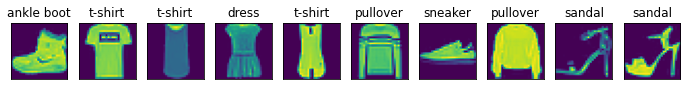

In [9]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fation_mnist(X, get_fashion_mnist_labels(y))

## 3.5.2 读取小批量


In [8]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [11]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

2.69 sec


# 3.6 softmax回归的从零开始实现

In [12]:
import torch 
import torchvision
import numpy as np 
import sys

# 3.6 softmax回归的从零开始实现

In [13]:
batch_size = 256
train_iter, test_iter = (train_iter, test_iter)

## 3.6.2 初始化模型参数

In [14]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

In [15]:
#同之前一样，我们需要模型参数梯度。
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 3.6.3 实现softmax运算

In [16]:
# 只对其中同一列（dim=0）或同一行（dim=1）的元素求和，并在结果中保留行和列这两个维度（keepdim=True）。
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


In [17]:
# softmax
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition # 这里应用了广播机制

In [19]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1540, 0.2183, 0.1431, 0.2160, 0.2686],
        [0.1768, 0.1291, 0.1664, 0.3135, 0.2142]]) tensor([1., 1.])


## 3.6.4 定义模型

In [21]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

In [26]:
y_hat =torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [22]:
# 交叉熵损失函数。
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1,1)))

## 3.6.6 计算分类准确率

In [27]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [28]:
print(accuracy(y_hat, y))

0.5


In [9]:
# 类似地，我们可以评价模型net在数据集data_iter上的准确率。
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [31]:
print(evaluate_accuracy(test_iter, net))

0.2008


## 训练模型


In [18]:
num_epochs, lr = 5, 0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

## 3.6.8 预测


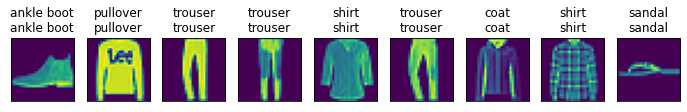

In [38]:
X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fation_mnist(X[0:9], titles[0:9])

# 3.7 softmax回归的简洁实现

In [3]:
import torch
from torch import nn
from torch.nn import init
import numpy as np 

## 3.7.1 获取和读取数据

In [ ]:
batch_size = 256

## 3.7.2 定义和初始化模型

In [10]:
num_inputs = 784
num_outputs = 10

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x):
        y = self.linear(x.view(x.shape[0], -1))
        return y

net = LinearNet(num_inputs, num_outputs)

对x的形状转换的这个功能自定义一个FlattenLayer并记录在d2lzh_pytorch中方便后面使用。

In [11]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

In [12]:
# 构建模型
from collections import OrderedDict

net = nn.Sequential(
    OrderedDict([
        ('flatten', FlattenLayer()),
        ('linear', nn.Linear(num_inputs, num_outputs))
    ])
)

In [14]:
# 然后，我们使用均值为0、标准差为0.01的正态分布随机初始化模型的权重参数。
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 3.7.3 softmax和交叉熵损失函数

In [15]:
loss = nn.CrossEntropyLoss()

In [17]:
# 定义优化器
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [19]:
# 训练模型
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.751, test acc 0.792
epoch 2, loss 0.0022, train acc 0.814, test acc 0.796
epoch 3, loss 0.0021, train acc 0.826, test acc 0.811
epoch 4, loss 0.0020, train acc 0.832, test acc 0.823
epoch 5, loss 0.0019, train acc 0.837, test acc 0.828


# 3.8 多层感知机

## 3.8.2 激活函数
### 3.8.2.1 ReLU函数

In [24]:
%matplotlib inline 
import torch
import numpy as np 
import matplotlib.pylab as plt

def xyplot(x_vals, y_vals, name):
    set_figsize(figsize=(5,2.5))
    plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

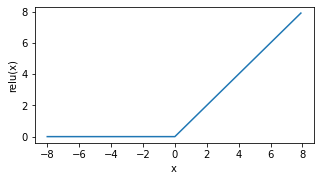

In [29]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

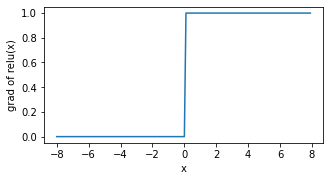

In [30]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

### 3.8.2.2 sigmoid函数 

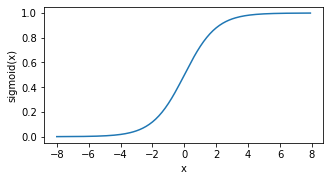

In [31]:
y = x.sigmoid()
xyplot(x, y , 'sigmoid')

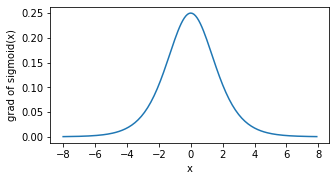

In [32]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

### 3.8.2.3 tanh函数

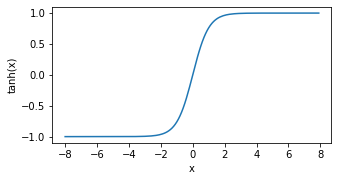

In [33]:
y = x.tanh()
xyplot(x, y, 'tanh')

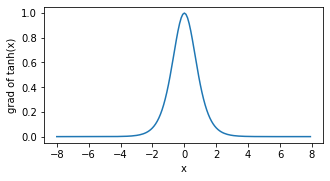

In [34]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

# 3.9 多层感知机的从零开始实现

In [35]:
import torch
import numpy as np

## 3.9.2 定义模型参数

In [36]:
num_inputs , num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

## 3.9.3 定义激活函数

In [37]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

In [38]:
# 定义模型
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

In [39]:
# 定义损失函数
loss = torch.nn.CrossEntropyLoss()

In [44]:
# 训练
num_epochs, lr = 5, 100.0
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr=lr)

epoch 1, loss 0.0030, train acc 0.718, test acc 0.725
epoch 2, loss 0.0019, train acc 0.820, test acc 0.813
epoch 3, loss 0.0017, train acc 0.843, test acc 0.825
epoch 4, loss 0.0015, train acc 0.856, test acc 0.837
epoch 5, loss 0.0014, train acc 0.864, test acc 0.841


## 3.10 多层感知机的简洁实现

In [45]:
import torch
from torch import nn
from torch.nn import init
import numpy as np

## 3.10.1 定义模型

In [46]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
)

for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

In [47]:
net

Sequential(
  (0): FlattenLayer()
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

## 3.10.2 读取数据并训练模型

In [48]:
batch_size = 256
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.705, test acc 0.796
epoch 2, loss 0.0019, train acc 0.821, test acc 0.815
epoch 3, loss 0.0016, train acc 0.846, test acc 0.808
epoch 4, loss 0.0015, train acc 0.858, test acc 0.836
epoch 5, loss 0.0014, train acc 0.863, test acc 0.818


# 3.11 模型选择、欠拟合和过拟合
## 3.11.4 多项式函数拟合实验

In [2]:
%matplotlib inline
import torch
import numpy as np 

In [22]:
# 生成数据集
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [23]:
features[:2],poly_features[:2], labels[:2]

(tensor([[ 0.0617],
         [-1.3416]]),
 tensor([[ 6.1705e-02,  3.8075e-03,  2.3495e-04],
         [-1.3416e+00,  1.7999e+00, -2.4147e+00]]),
 tensor([  5.0659, -16.2650]))

## 3.11.4.2 定义、训练和测试模型

In [6]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [20]:
# 训练
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

## 3.11.4.3 三阶多项式函数拟合（正常）

final epoch: train loss 0.00011059059033868834 test loss 9.076373680727556e-05
weight: tensor([[ 1.2017, -3.4006,  5.6001]]) 
bias: tensor([4.9987])


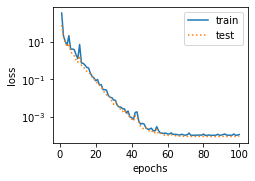

In [24]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],labels[:n_train], labels[n_train:])

## 3.11.4.4 线性函数拟合（欠拟合）

final epoch: train loss 519.1417846679688 test loss 196.84539794921875
weight: tensor([[25.1276]]) 
bias: tensor([-0.3189])


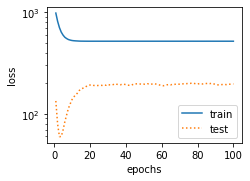

In [25]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

## 3.11.4.5 训练样本不足（过拟合）

final epoch: train loss 1.760236382484436 test loss 228.23297119140625
weight: tensor([[ 2.9092, -2.3477,  4.4976]]) 
bias: tensor([2.9798])


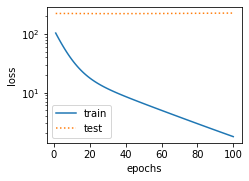

In [27]:
fit_and_plot(poly_features[0:3, :], poly_features[n_train, :], labels[0:3], labels[n_train:])